# Environment setup

In [119]:
# Standard library imports
import os
import sys
import warnings
from pathlib import Path
from typing import List, Union, Tuple

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP

# Project imports
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

# Suppress warnings
warnings.filterwarnings('ignore')

# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3')

from importlib import reload
from BrainAtlas.mouse.ac_create_scRNAseq_set_functions import *
reload(sys.modules['BrainAtlas.mouse.ac_create_scRNAseq_set_functions'])

# Print the current working directory to confirm the change
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3


In [115]:
# Initialize cache
download_base = Path('./DATA/abc_atlas')
download_base.mkdir(parents=True, exist_ok=True)
abc_cache = AbcProjectCache.from_cache_dir(download_base)
abc_cache.load_latest_manifest()
abc_cache.current_manifest

'releases/20241115/manifest.json'

# Dataset exploration

In [61]:
# List available directories
print("Available directories:")
print(abc_cache.list_directories)  # Access the list attribute directly, don't call it as a function

# List available metadata files in WMB-10X directory
print("\nAvailable metadata files in WMB-10X directory:")
print(abc_cache.list_metadata_files('WMB-10X'))

Available directories:
['Allen-CCF-2020', 'MERFISH-C57BL6J-638850', 'MERFISH-C57BL6J-638850-CCF', 'MERFISH-C57BL6J-638850-imputed', 'MERFISH-C57BL6J-638850-sections', 'WHB-10Xv3', 'WHB-taxonomy', 'WMB-10X', 'WMB-10XMulti', 'WMB-10Xv2', 'WMB-10Xv3', 'WMB-neighborhoods', 'WMB-taxonomy', 'Zhuang-ABCA-1', 'Zhuang-ABCA-1-CCF', 'Zhuang-ABCA-2', 'Zhuang-ABCA-2-CCF', 'Zhuang-ABCA-3', 'Zhuang-ABCA-3-CCF', 'Zhuang-ABCA-4', 'Zhuang-ABCA-4-CCF']

Available metadata files in WMB-10X directory:
['cell_metadata', 'cell_metadata_with_cluster_annotation', 'example_genes_all_cells_expression', 'gene', 'region_of_interest_metadata']


## Cell metadata

In [62]:
# Load and process metadata first
print("Loading metadata...")
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata'
)

Loading metadata...


In [63]:
cell_metadata.head(3)

,cell_label,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,abc_sample_id
0,GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.146826,-3.086639,1,484be5df-5d44-4bfe-9652-7b5bc739c211
1,AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.138481,-3.022000,1,5638505d-e1e8-457f-9e5b-59e3e2302417
2,AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.472557,-2.992709,1,a0544e29-194f-4d34-9af4-13e7377b648f


In [64]:
print(cell_metadata.library_method.unique(), "\n")
print(cell_metadata.region_of_interest_acronym.unique(), "\n")
print(len(list(cell_metadata.cluster_alias.unique())), "\n")

['10Xv3' '10Xv2' '10xRSeq_Mult'] 

['RHP' 'RSP' 'ACA' 'PL-ILA-ORB' 'AUD-TEa-PERI-ECT' 'SS-GU-VISC' 'MO-FRP'
 'PAL' 'sAMY' 'CTXsp' 'HY' 'STRv' 'OLF' 'LSX' 'AI' 'STRd' 'VIS-PTLp' 'VIS'
 'TH' 'MOp' 'ENT' 'HIP' 'P' 'MB' 'MY' 'CB' 'AUD' 'SSp' 'TEa-PERI-ECT'] 

5322 



## Annotation metadata

In [65]:
print(abc_cache.list_metadata_files('WMB-taxonomy'))

['cluster', 'cluster_annotation_term', 'cluster_annotation_term_set', 'cluster_annotation_term_with_counts', 'cluster_to_cluster_annotation_membership', 'cluster_to_cluster_annotation_membership_color', 'cluster_to_cluster_annotation_membership_pivoted']


In [66]:
cluster_annotation = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

In [67]:
cluster_annotation.shape

(26610, 7)

In [68]:
cluster_annotation.columns

Index(['cluster_annotation_term_label', 'cluster_annotation_term_set_label',
       'cluster_alias', 'cluster_annotation_term_name',
       'cluster_annotation_term_set_name', 'number_of_cells',
       'color_hex_triplet'],
      dtype='object')

In [69]:
cluster_annotation.head(3)

,cluster_annotation_term_label,cluster_annotation_term_set_label,cluster_alias,cluster_annotation_term_name,cluster_annotation_term_set_name,number_of_cells,color_hex_triplet
0,CS20230722_CLUS_0001,CCN20230722_CLUS,128,0001 CLA-EPd-CTX Car3 Glut_1,cluster,4262,#00664E
1,CS20230722_CLUS_0002,CCN20230722_CLUS,129,0002 CLA-EPd-CTX Car3 Glut_1,cluster,3222,#5C79CC
2,CS20230722_CLUS_0003,CCN20230722_CLUS,130,0003 CLA-EPd-CTX Car3 Glut_1,cluster,12216,#86FF4D


In [70]:
print(len(cluster_annotation.cluster_alias.unique()), "\n")
print(min(cluster_annotation.cluster_alias.unique()), "\n")
print(max(cluster_annotation.cluster_alias.unique()), "\n")


5322 

1 

34380 



In [75]:
print(f"cluster_annotation_term_name: {len(cluster_annotation.cluster_annotation_term_name.unique())}")
print(f"cluster_annotation_term_label: {len(cluster_annotation.cluster_annotation_term_label.unique())}")
print(f"cluster_annotation_term_set_label: {len(cluster_annotation.cluster_annotation_term_set_label.unique())}")
print(f"cluster_annotation_term_set_name: {len(cluster_annotation.cluster_annotation_term_set_name.unique())}")
print(f"color_hex_triplet: {len(cluster_annotation.color_hex_triplet.unique())}")


cluster_annotation_term_name: 6904
cluster_annotation_term_label: 6905
cluster_annotation_term_set_label: 5
cluster_annotation_term_set_name: 5
color_hex_triplet: 6273


In [77]:
print(f"cluster_annotation_term_set_name: {cluster_annotation.cluster_annotation_term_set_name.unique()}")

cluster_annotation_term_set_name: ['cluster' 'supertype' 'subclass' 'class' 'neurotransmitter']


## Process metadata

In [72]:
# Process metadata
# Set cell label as index for easier lookup later
cell_metadata.set_index('cell_label', inplace=True)

# Create dictionary to store cluster annotations
# Structure: {cluster_alias: {term_set_label: term_name}}
cluster_annotations = {}

# Iterate through cluster annotation data to build lookup dictionary
for _, row in cluster_annotation.iterrows():
    alias = row['cluster_alias']
    term_set = row['cluster_annotation_term_set_name']
    term_name = row['cluster_annotation_term_name']
    
    # Initialize nested dictionary for new cluster aliases
    if alias not in cluster_annotations:
        cluster_annotations[alias] = {}
    
    # Store the term name under term_set_label key for this cluster
    cluster_annotations[alias][f"{term_set}_label"] = term_name

In [73]:
cluster_annotations[list(cluster_annotations.keys())[0]]


{'cluster_label': '0001 CLA-EPd-CTX Car3 Glut_1',
 'supertype_label': '0001 CLA-EPd-CTX Car3 Glut_1',
 'subclass_label': '001 CLA-EPd-CTX Car3 Glut',
 'class_label': '01 IT-ET Glut',
 'neurotransmitter_label': 'Glut'}

# Add annotations to cell metadata

In [78]:
# Add annotations to cell metadata
for col in ['neurotransmitter_label', 'class_label', 'subclass_label', 'cluster_label']:
    cell_metadata[col] = [
        cluster_annotations.get(alias, {}).get(col, 'Unknown')
        for alias in cell_metadata['cluster_alias']
    ]

In [80]:
print(f"library_method: {cell_metadata.library_method.unique()}")
print(f"region_of_interest_acronym: {cell_metadata.region_of_interest_acronym.unique()}")
print(f"class_label: {len(list(cell_metadata.class_label.unique()))}")
print(f"subclass_label: {len(list(cell_metadata.subclass_label.unique()))}")
print(f"cluster_label: {len(list(cell_metadata.cluster_label.unique()))}")
print(f"neurotransmitter_label: {len(list(cell_metadata.neurotransmitter_label.unique()))}")


library_method: ['10Xv3' '10Xv2' '10xRSeq_Mult']
region_of_interest_acronym: ['RHP' 'RSP' 'ACA' 'PL-ILA-ORB' 'AUD-TEa-PERI-ECT' 'SS-GU-VISC' 'MO-FRP'
 'PAL' 'sAMY' 'CTXsp' 'HY' 'STRv' 'OLF' 'LSX' 'AI' 'STRd' 'VIS-PTLp' 'VIS'
 'TH' 'MOp' 'ENT' 'HIP' 'P' 'MB' 'MY' 'CB' 'AUD' 'SSp' 'TEa-PERI-ECT']
class_label: 34
subclass_label: 338
cluster_label: 5322
neurotransmitter_label: 10


In [81]:
cell_metadata.head(3)

,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,abc_sample_id,neurotransmitter_label,class_label,subclass_label,cluster_label
cell_label,,,,,,,,,,,,,,,,,,,,
GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.146826,-3.086639,1,484be5df-5d44-4bfe-9652-7b5bc739c211,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3
AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.138481,-3.022000,1,5638505d-e1e8-457f-9e5b-59e3e2302417,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3
AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.472557,-2.992709,1,a0544e29-194f-4d34-9af4-13e7377b648f,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3


In [89]:
# feature matrix label
available_regions = cell_metadata['feature_matrix_label'].unique()
print(f"Available regions (feature_matrix_label): \n {available_regions}, length: {len(available_regions)}")

# region of interest acronym
print("\n")
available_regions = cell_metadata['region_of_interest_acronym'].unique()
print(f"Available regions (region_of_interest_acronym): \n {available_regions}, length: {len(available_regions)}")

# brain section label
print("\n")
brain_sections = cell_metadata['brain_section_label'].unique()
print(f"brain_section_label: \n {brain_sections}, length: {len(brain_sections)}")

# entity
print("\n")
entities = cell_metadata['entity'].unique()
print(f"entity: \n {entities}, length: {len(entities)}")


Available regions (feature_matrix_label): 
 ['WMB-10Xv3-HPF' 'WMB-10Xv3-Isocortex-1' 'WMB-10Xv3-PAL' 'WMB-10Xv3-STR'
 'WMB-10Xv3-CTXsp' 'WMB-10Xv3-HY' 'WMB-10Xv3-OLF' 'WMB-10Xv3-TH'
 'WMB-10Xv3-P' 'WMB-10Xv3-MB' 'WMB-10Xv3-MY' 'WMB-10Xv3-CB'
 'WMB-10Xv3-Isocortex-2' 'WMB-10Xv2-HPF' 'WMB-10Xv2-Isocortex-1'
 'WMB-10Xv2-HY' 'WMB-10Xv2-TH' 'WMB-10Xv2-OLF' 'WMB-10Xv2-CTXsp'
 'WMB-10Xv2-MB' 'WMB-10Xv2-Isocortex-2' 'WMB-10Xv2-Isocortex-3'
 'WMB-10Xv2-Isocortex-4' 'WMB-10XMulti'], length: 24


Available regions (region_of_interest_acronym): 
 ['RHP' 'RSP' 'ACA' 'PL-ILA-ORB' 'AUD-TEa-PERI-ECT' 'SS-GU-VISC' 'MO-FRP'
 'PAL' 'sAMY' 'CTXsp' 'HY' 'STRv' 'OLF' 'LSX' 'AI' 'STRd' 'VIS-PTLp' 'VIS'
 'TH' 'MOp' 'ENT' 'HIP' 'P' 'MB' 'MY' 'CB' 'AUD' 'SSp' 'TEa-PERI-ECT'], length: 29


brain_section_label: 
 [nan], length: 1


entity: 
 ['cell'], length: 1


In [92]:
cell_metadata['region_of_interest_acronym'].value_counts()

region_of_interest_acronym
MB                  367029
VIS                 321908
OLF                 280744
HY                  262175
TH                  261009
MOp                 247660
MY                  192533
CB                  182004
HIP                 176122
P                   143616
CTXsp               122208
sAMY                120764
RSP                 112248
ENT                 110210
PAL                 108046
PL-ILA-ORB          106122
SS-GU-VISC          103192
ACA                 102794
RHP                 102008
AI                   99046
SSp                  75852
MO-FRP               71399
AUD                  70564
TEa-PERI-ECT         59160
STRd                 55626
VIS-PTLp             54625
LSX                  53819
STRv                 53573
AUD-TEa-PERI-ECT     26920
Name: count, dtype: int64

# SRRM3 and SRRM4 expression

In [116]:
# Analysis parameters
datasets = ['WMB-10X']

In [117]:
print(cell_metadata['dataset_label'].unique())
print(cell_metadata['feature_matrix_label'].unique())

['WMB-10Xv3' 'WMB-10Xv2' 'WMB-10XMulti']
['WMB-10Xv3-HPF' 'WMB-10Xv3-Isocortex-1' 'WMB-10Xv3-PAL' 'WMB-10Xv3-STR'
 'WMB-10Xv3-CTXsp' 'WMB-10Xv3-HY' 'WMB-10Xv3-OLF' 'WMB-10Xv3-TH'
 'WMB-10Xv3-P' 'WMB-10Xv3-MB' 'WMB-10Xv3-MY' 'WMB-10Xv3-CB'
 'WMB-10Xv3-Isocortex-2' 'WMB-10Xv2-HPF' 'WMB-10Xv2-Isocortex-1'
 'WMB-10Xv2-HY' 'WMB-10Xv2-TH' 'WMB-10Xv2-OLF' 'WMB-10Xv2-CTXsp'
 'WMB-10Xv2-MB' 'WMB-10Xv2-Isocortex-2' 'WMB-10Xv2-Isocortex-3'
 'WMB-10Xv2-Isocortex-4' 'WMB-10XMulti']


In [120]:
# Load data
genes = ['Srrm3', 'Srrm4']
expression_data, metadata = load_multi_region_data(
    cell_metadata=cell_metadata,
    abc_cache=abc_cache,
    datasets=datasets,
    genes=genes,
    dataset_regions=['ENT', 'HIP', 'P', 'MB']
)

Processing WMB-10Xv3-HPF
Found 131297 cells in WMB-10Xv3-HPF
Processing WMB-10Xv3-P


WMB-10Xv3-P-log2.h5ad: 100%|██████████████████████████████████████████████████| 5.20G/5.20G [05:25<00:00, 16.0MMB/s]


Found 143157 cells in WMB-10Xv3-P
Processing WMB-10Xv3-MB


WMB-10Xv3-MB-log2.h5ad: 100%|█████████████████████████████████████████████████| 13.7G/13.7G [15:17<00:00, 15.0MMB/s]


Found 337101 cells in WMB-10Xv3-MB
Processing WMB-10Xv2-HPF
Found 155033 cells in WMB-10Xv2-HPF
Processing WMB-10Xv2-MB
Found 29781 cells in WMB-10Xv2-MB
Processing WMB-10XMulti
Found 608 cells in WMB-10XMulti


In [121]:
expression_data.head(5)

gene_symbol,Srrm4,Srrm3,region,dataset
CATGCAACAAACCACT-419_A05,5.952569,6.749905,HIP,WMB-10Xv3
TTCAATCGTTTCGATG-447_A06,0.000000,0.000000,HIP,WMB-10Xv3
GGAATCTGTCGCCTAG-420_B06,0.000000,6.310520,HIP,WMB-10Xv3
CATTCATTCGCAGAGA-444_A04,0.000000,0.000000,HIP,WMB-10Xv3
AATGCCAAGTATGGAT-447_A06,0.000000,0.000000,HIP,WMB-10Xv3


In [122]:
expression_data.region.unique()

array(['HIP', 'ENT', 'P', 'MB'], dtype=object)


Creating region-specific box plots...
Statistical Summary:


Region: ENT

01 IT-ET Glut:
  Srrm3: mean=5.78, median=6.93, n=41674
  Srrm4: mean=5.28, median=6.62, n=41674

05 OB-IMN GABA:
  Srrm3: mean=3.82, median=2.89, n=26
  Srrm4: mean=4.71, median=7.08, n=26

06 CTX-CGE GABA:
  Srrm3: mean=4.65, median=6.62, n=6141
  Srrm4: mean=4.95, median=6.77, n=6141

12 HY GABA:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

14 HY Glut:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

19 MB Glut:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

20 MB GABA:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

21 MB Dopa:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

23 P Glut:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

27 MY GABA:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

28 CB GABA:
  Srrm3: mean=7.08, median=7.08, n=2
  Srrm4

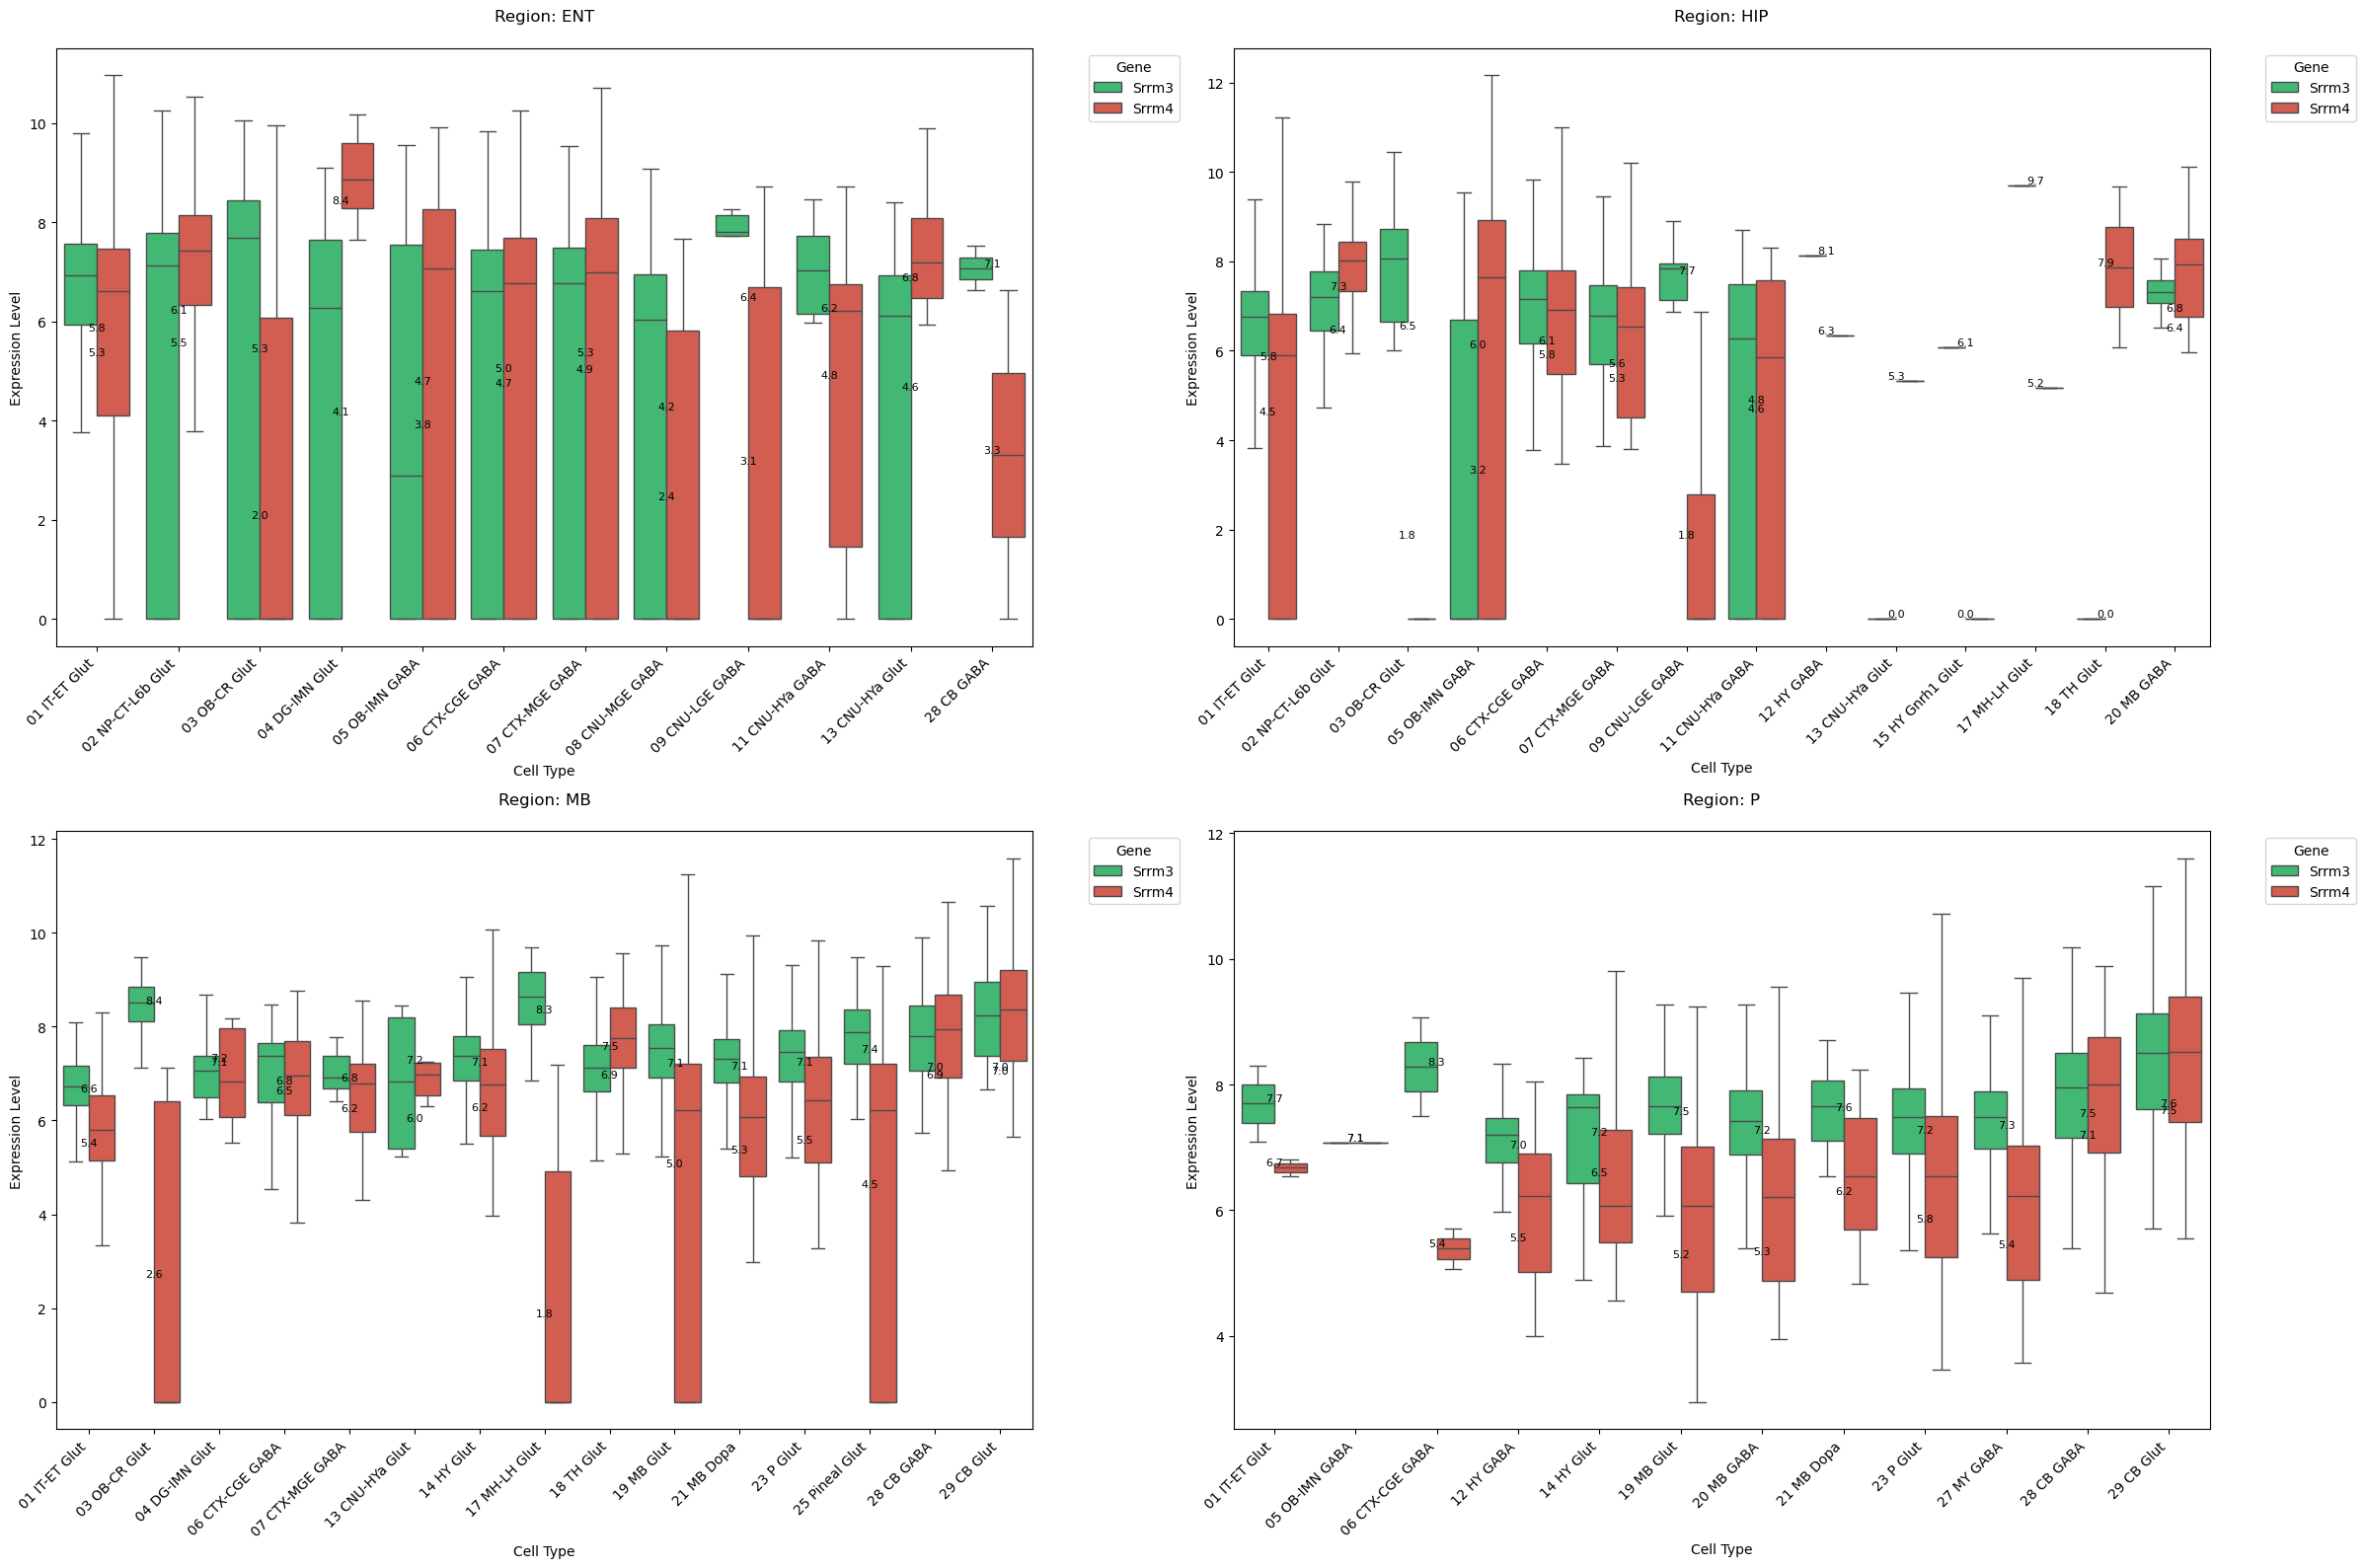

In [123]:
# Create visualizations
print("\nCreating region-specific box plots...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='class_label',
    figsize=(12, 8),
    top_n=10  # Show top 10 groups by expression
)
plt.show()

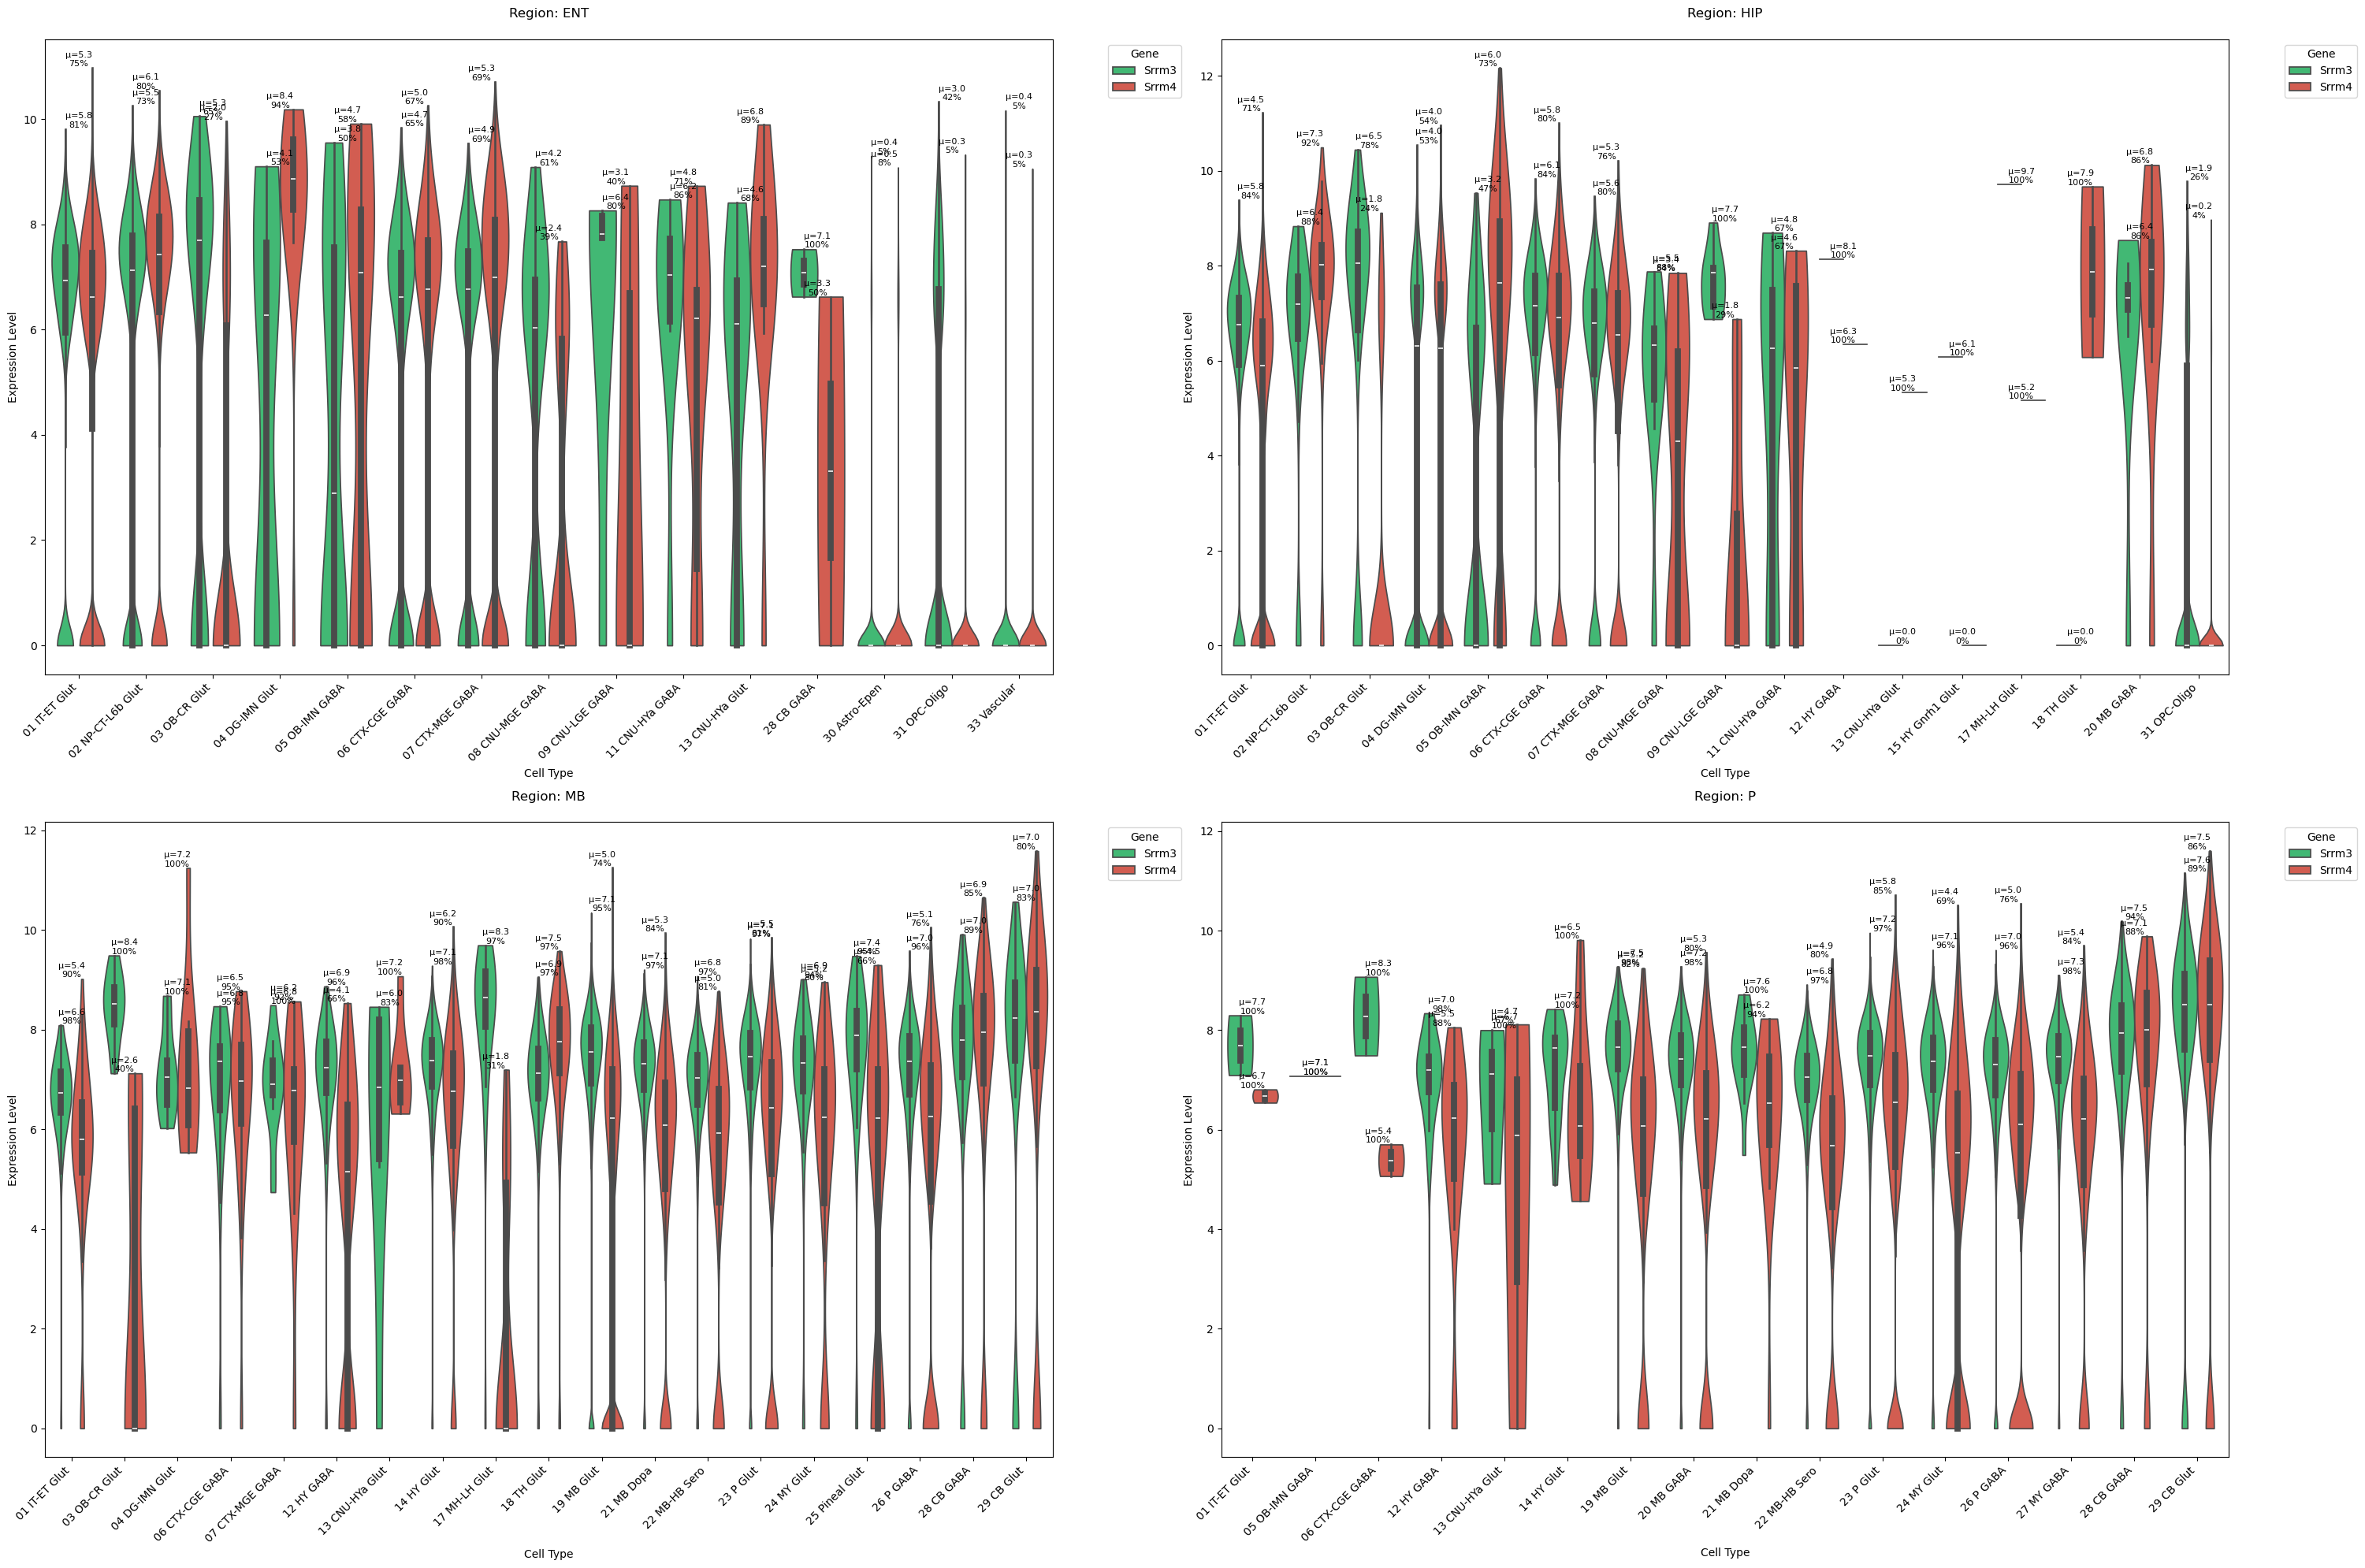

In [124]:
fig, axes = plot_region_gene_comparison_cleaned(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='class_label',
    min_expr_threshold=0.1
)

In [125]:
expression_data.head(5)

gene_symbol,Srrm4,Srrm3,region,dataset
CATGCAACAAACCACT-419_A05,5.952569,6.749905,HIP,WMB-10Xv3
TTCAATCGTTTCGATG-447_A06,0.000000,0.000000,HIP,WMB-10Xv3
GGAATCTGTCGCCTAG-420_B06,0.000000,6.310520,HIP,WMB-10Xv3
CATTCATTCGCAGAGA-444_A04,0.000000,0.000000,HIP,WMB-10Xv3
AATGCCAAGTATGGAT-447_A06,0.000000,0.000000,HIP,WMB-10Xv3


In [126]:
sample_df = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata['class_label'] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })

sample_df.head(5)

,Expression,Gene,Group,Region
CATGCAACAAACCACT-419_A05,6.749905,Srrm3,01 IT-ET Glut,HIP
TTCAATCGTTTCGATG-447_A06,0.000000,Srrm3,04 DG-IMN Glut,HIP
GGAATCTGTCGCCTAG-420_B06,6.310520,Srrm3,31 OPC-Oligo,HIP
CATTCATTCGCAGAGA-444_A04,0.000000,Srrm3,05 OB-IMN GABA,HIP
AATGCCAAGTATGGAT-447_A06,0.000000,Srrm3,30 Astro-Epen,HIP


In [127]:
sample_df[(sample_df.Region == 'HPF') & (sample_df.Group == '12 HY GABA')].head(5)


,Expression,Gene,Group,Region



Creating region-specific box plots...
Statistical Summary:


Region: ENT

Chol:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

Dopa:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

GABA:
  Srrm3: mean=4.84, median=6.74, n=14973
  Srrm4: mean=5.11, median=6.89, n=14973

GABA-Glyc:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

Glut:
  Srrm3: mean=5.66, median=6.99, n=64190
  Srrm4: mean=5.54, median=6.89, n=64190

Glut-GABA:
  Srrm3: mean=3.79, median=5.46, n=272
  Srrm4: mean=5.56, median=6.80, n=272

Nora:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

Sero:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

Region: HIP

Chol:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

Dopa:
  Srrm3: mean=0.00, median=0.00, n=1
  Srrm4: mean=0.00, median=0.00, n=1

GABA:
  Srrm3: mean=5.92, median=7.02, n=15633
  Srrm4: mean=5.57, median=6.75, n=15633

GABA-Gl

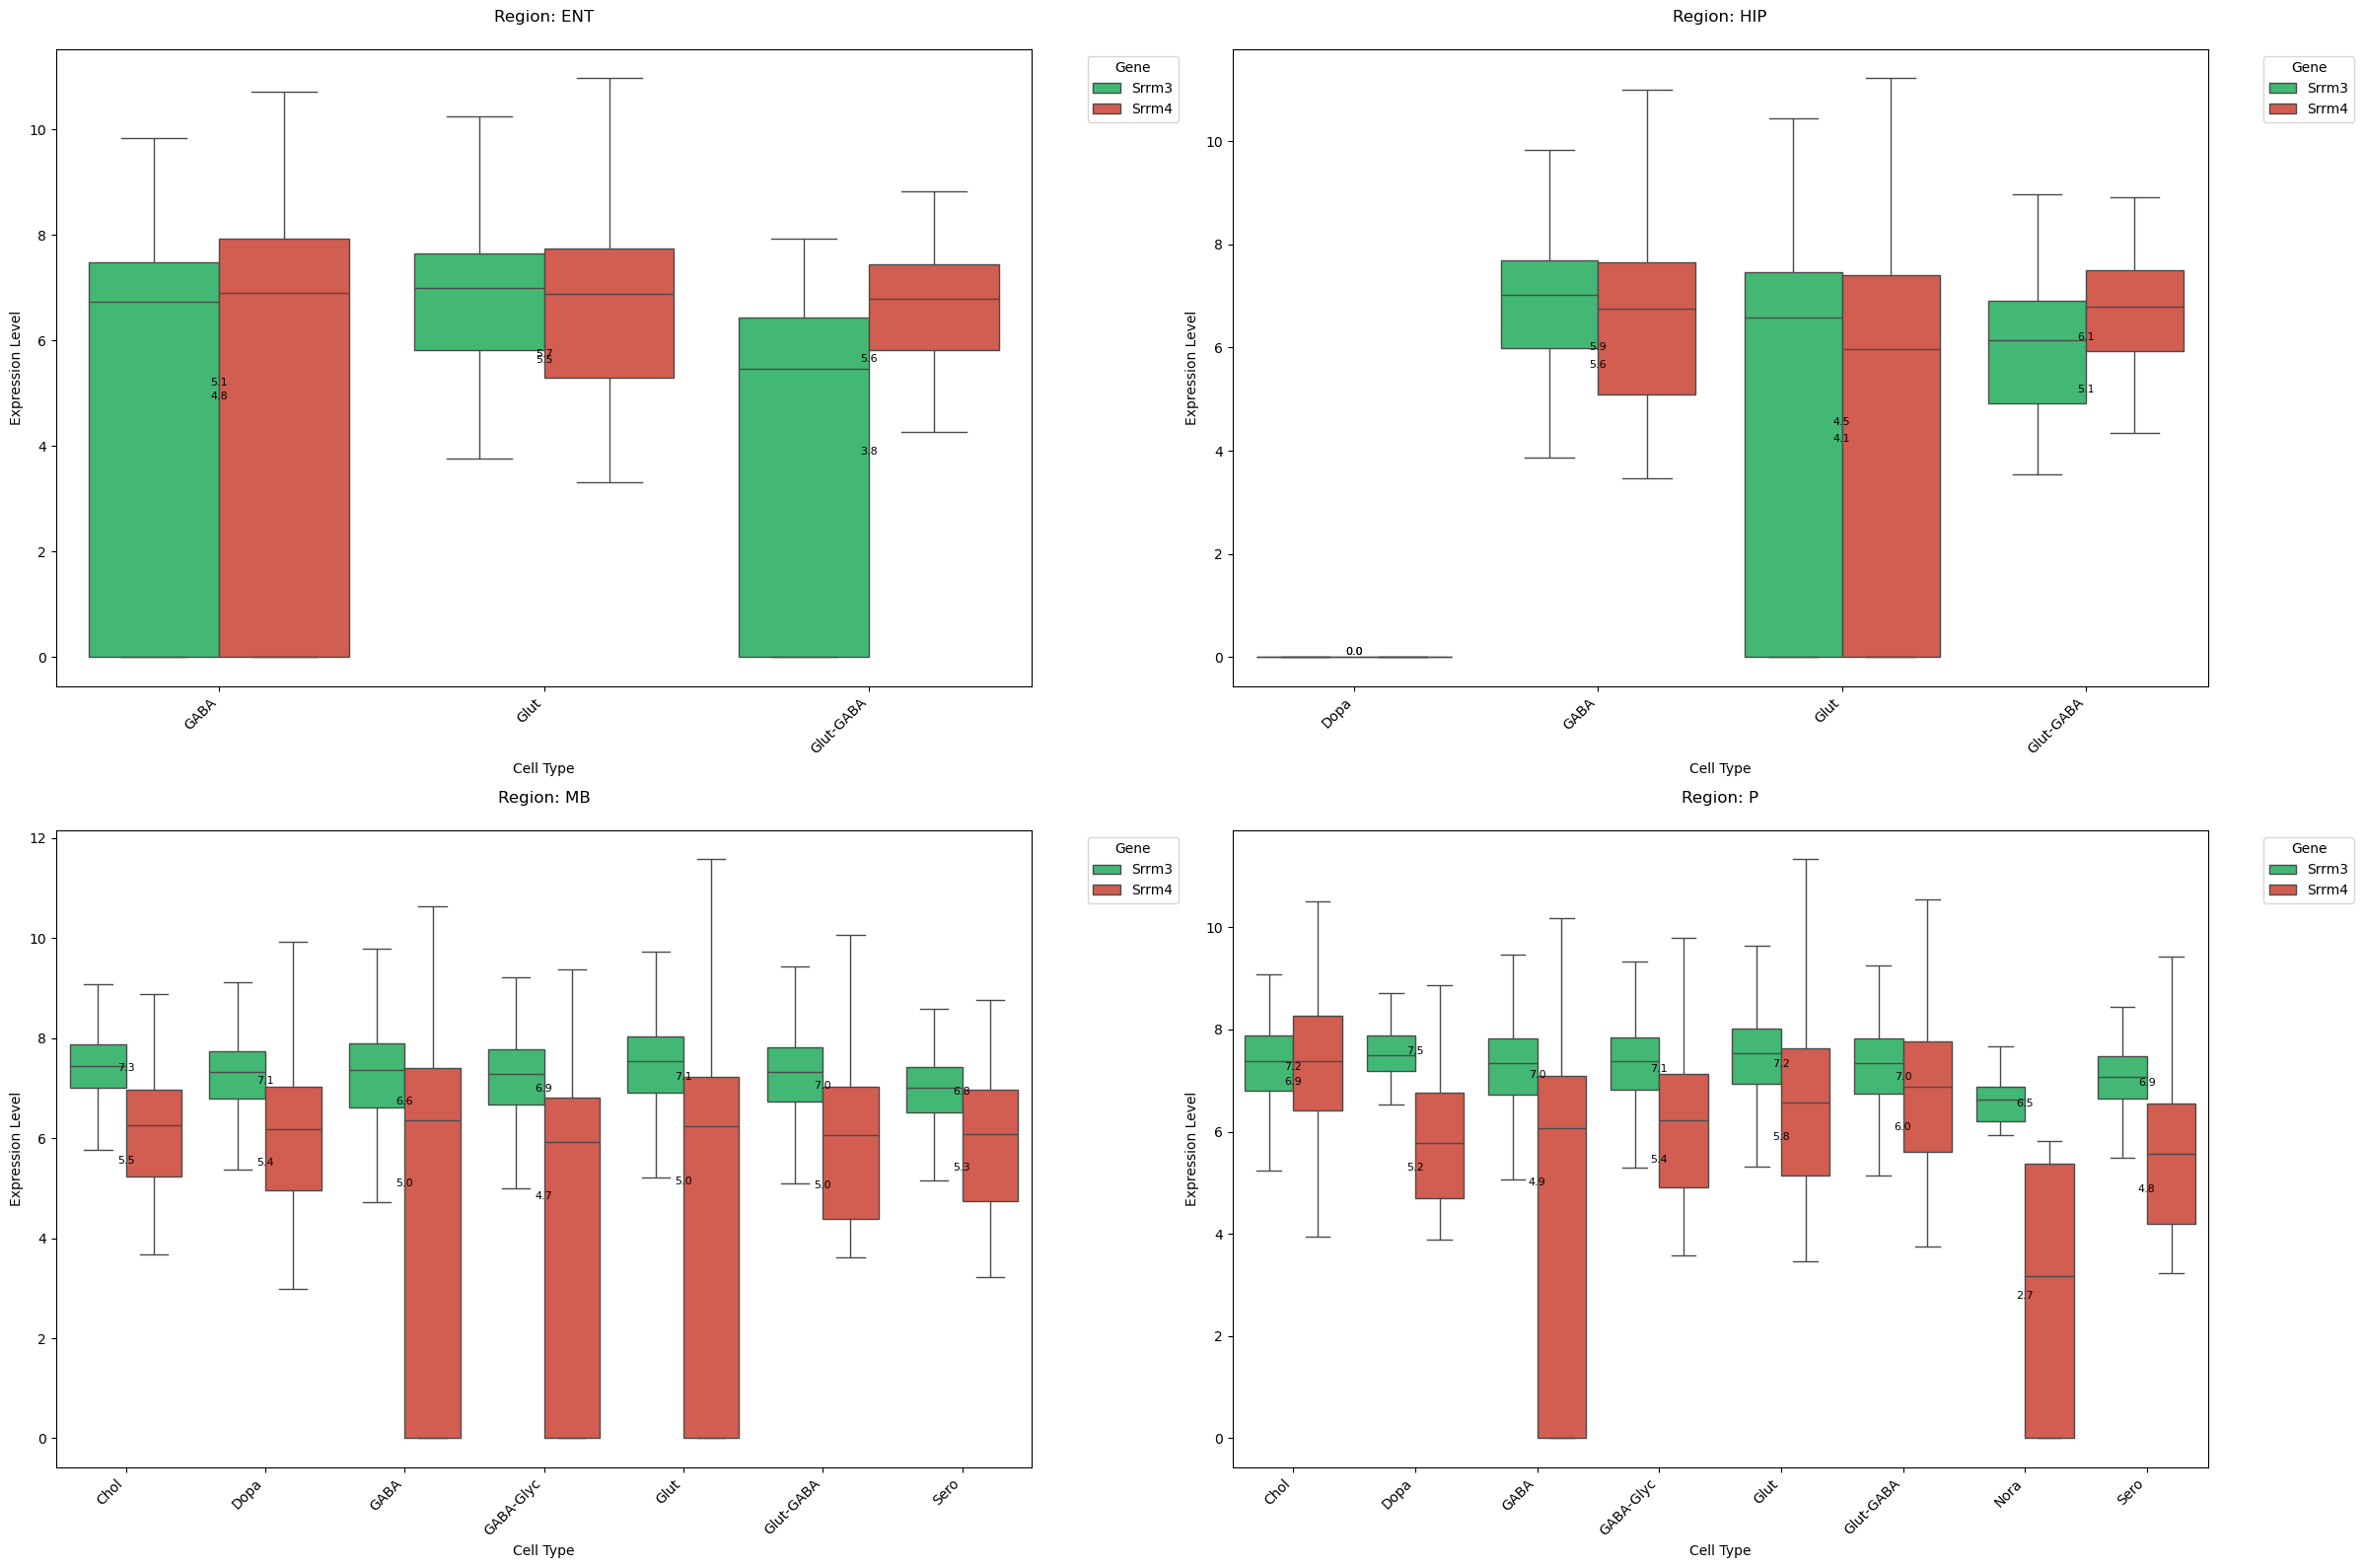

In [128]:
# Create visualizations
print("\nCreating region-specific box plots...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='neurotransmitter_label',
    figsize=(12, 8),
    top_n=10 # Show top 10 groups by expression
)
plt.show()

In [130]:
# print("\nCreating dimension reduction plots...")
# fig, _ = create_dimension_reduction_plot(
#     expression_data,
#     metadata,
#     method='umap',
#     color_by=['class_label', 'neurotransmitter_label', 'region'],
#     genes=genes
# )
# plt.show()